In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Game Description

**Game info**: <br>
- two players: Small-Blind (SB) and Big-Blind (BB)
- both SB and BB have a initial stack of $V_{SB}$ and $V_{BB}$ 

**Game mechanics**:
1. A hand is dealt to SB and BB. Hand chosen based on $U(0,1)$   
2. SB pays 0.5
3. BB pays 1.0
4. SB decided to either fold or jam (go all-in)
5. If SB jams, BB decides to either call or fold
6. The better hand wins. The lower, the better.
     - There is a certain probability that the worse hand wins

# Solution in simplified case:

## SetUp
- $V_{SB} = V_{BB} = 2$ 
- $p_{worseHandWins} = \frac{1}{3}$
     
- $y$: hand that SB has
- $x$: hand that BB has
- $y^*$ is the treshold for the SB for making jam/fold decision
    - if $y$ is < $y^*$: jam, otherwise fold
- $x^*$ is the treshold for the BB to call/fold
    - it makes sense to always call as BB if the bets of SB are so small compared to pot
    - $x^*=1$ in this setup
    
## Question
- given a hand $y$, what is the expected value of the game for the SB
    - assume that the BB uses $x^*=1$
    
## Solution
There are two actions that BB can take, and each of those have their own expectation. <br>
Terminology:
- $p_w$ probability of winning the pot
- $p_l$ probability of losing the pot
- $PnL_w$ PnL that is received for winning wrt the stack before the game
    - $PnL_w = V_w - V_0$
    - this is the difference in stack after winning the pot ($V_w$) compared to 
      before the game ($V_0$)
- $p_{rev}$ probability of reversing who is winning
    - normally, the lower hand wins, but with $p_{rev}$ the higher one wins

### Expected value for folding
- $<\text{SB},\text{Fold}|y> = p_w * PnL_w + p_l * PnL_l$
- $<\text{SB},\text{Fold}|y> = 0.0 + 1.0 * (V_l - V_0) = 1.0 * (1.5 - 2.0)$
    - if SB folds, they just lose the SB of $0.5$
- $<\text{SB},\text{Fold}|y> = -0.5$

### Expected value for jamming
- $<\text{SB},\text{Jam}|y> = p_w|y * PnL_w + p_l|y * PnL_l$
    - $p_w|y = p_{yBetter}*(1-p_{rev}) + p_{yWorse}*p_{rev}$ 
    - $PnL_w = V_w - V_0 = S = 4-2=2$
    - $p_l|y = p_{yBetter}*p_{rev} + p_{yWorse}*(1-p_{rev})$ 
    - $PnL_l = V_l - V_0 = -S = 0-2=-2$
    
- compute the probability that a given $y$ is better than $x \sim U(0,1)$
    - $p_{yBetter}$: 
      $y$ is better than $x$ if $x \epsilon [y,1]$, the probability of that is $1-y$
    - $p_{yWorse}$
      $y$ is worse than $x$ if $x \epsilon [0,y]$, the probability of that is $y$
    
    
- $<\text{SB},\text{Jam}|y> = ((1-y)*(1-p_{rev}) + y*p_{rev}) * S + \\
                ((1-y)*p_{rev} + (1-y)*(1-p_{rev}) * (-S)$

- rearranging this equation gives:
\begin{equation}
<\text{SB},\text{Jam}|y> = 2S \Big( 2yp_{rev} - y - p_{rev} + \frac{1}{2} \Big)
\end{equation}

- Solution for $S=2, p_{rev}=\frac{1}{3}$ (used in implementation examples)
    - $<\text{SB},\text{Jam}|y> = -\frac{4}{3}y + \frac{2}{3}$
    
### What is the value of $Y^*$
- jam whenever jamming has higher EV than folding
- folding always has EV of $-\frac{1}{2}$
- setting the EV of folding and jamming equal results in:
    - $y^* = \frac{3}{4} + \frac{1}{2}$

# Solution in generic case:

# Implementation

In [28]:
class PlayerSB:
    def __init__(self, hand, jam_treshold):
        self.hand = hand
        self.jam_treshold = jam_treshold # jam if hand < treshold
        
    def make_decision(self):
        if self.hand <= self.jam_treshold:
            return "JAM"
        else:
            return "FOLD"
        
class PlayerBB:
    def __init__(self, hand, call_treshold):
        self.hand = hand
        self.call_treshold = call_treshold # call if hand < treshold
        
    def make_decision(self):
        if self.hand <= self.call_treshold:
            return "CALL"
        else:
            return "FOLD"

In [62]:
class Game_JamFold:
    def __init__(self, V_SB, V_BB, smallBlind, bigBlind, prob_winWithWorseHand, player_SB, player_BB):
        self.V_SB = V_SB
        self.V_BB = V_BB
        
        self.SB = smallBlind
        self.BB = bigBlind
        
        self.prob_winWithWorseHand = prob_winWithWorseHand
        
        self.player_SB = player_SB
        self.player_BB = player_BB
        
    def play(self):
        pot = 0.0
        
        # step 1: take blinds
        V_SB = self.V_SB
        V_BB = self.V_BB
        
        V_SB -= self.SB
        pot += self.SB
        
        V_BB -= self.BB
        pot += self.BB
        
        # step 2: SB-player needs to decide what to do ["JAM", "FOLD"]
        action_SB = player_SB.make_decision()
        callAmount = None
        
        if action_SB == "FOLD":
            V_BB += pot
            pot = 0
            return {"winner": "BB", "V_SB": V_SB, "V_BB": V_BB}
        else:
            # first make the call to BB
            pot += self.BB - self.SB
            V_SB -= (self.BB - self.SB)
            
            # then jam all-in with rest
            callAmount = V_SB
            pot += callAmount
            V_SB -= callAmount
        
        # step 3: BB-player needs to decide what to do ["CALL", "FOLD"]
        action_BB = player_BB.make_decision()
        
        if action_BB == "FOLD":
            V_SB += pot
            pot = 0
            return {"winner": "SB", "V_SB": V_SB, "V_BB": V_BB}
        else:
            V_BB -= callAmount
            pot += callAmount
            
        # showdown: determine winning hand
        if player_SB.hand < player_BB.hand:
            winner = "SB"
        else:
            winner = "BB"
            
        # account for "luck" --> the better hand might still lose
        reverseResult = np.random.uniform(0.0, 1.0, 1)
        if reverseResult <= self.prob_winWithWorseHand:
            winner = "BB" if winner == "SB" else "SB"
            
        # allocate pot to winner
        if winner == "SB":
            V_SB += pot
        else:
            V_BB += pot
            
        return {"winner": winner, "V_SB": V_SB, "V_BB": V_BB}        

In [7]:
SB_hand, BB_hand = np.random.uniform(low=0.0, high=1.0, size=2)
print("X: {:.5f}, Y: {:.5f}".format(SB_hand, BB_hand))

X: 0.42157, Y: 0.70463


In [38]:
V_SB, V_BB = 2,2
player_SB = PlayerSB(hand=0.2, jam_treshold=0.5)
player_BB = PlayerBB(hand=0.7, call_treshold=1.0) # call everything

In [39]:
game = Game_JamFold(V_SB=V_SB, 
                    V_BB=V_BB, 
                    smallBlind=0.5, 
                    bigBlind=1.0, 
                    prob_winWithWorseHand=1.0/3.0, 
                    player_SB=player_SB, 
                    player_BB=player_BB)
game.play()

## Iterate through SB and BB hands

In [140]:
V_SB, V_BB = 2,2

df_results = pd.DataFrame(columns=[
    "i_hand","i_replay", "SB_hand", "BB_hand", "winner", "V_SB", "V_BB"])
SB_hand = 1.0/3.0

n_hands = 50
n_replay = 10
handSelection = "grid" # "random"

for SB_hand in np.concatenate((np.linspace(0, 0.5, 21), np.linspace(0.55, 1, 5))):
    for i in range(n_hands):
        if handSelection == "random":
            _, BB_hand = np.random.uniform(low=0.0, high=1.0, size=2)
        elif handSelection == "grid":
            minHand, maxHand = 0.0, 1.0
            BB_hand = minHand + i * (maxHand-minHand)/(n_hands-1)
        else:
            raise ValueError("Unknown value for \"handSelection\"")

        player_SB = PlayerSB(hand=SB_hand, jam_treshold=0.5)
        player_BB = PlayerBB(hand=BB_hand, call_treshold=1.0) # call everything

        game = Game_JamFold(V_SB=V_SB, 
                            V_BB=V_BB, 
                            smallBlind=0.5, 
                            bigBlind=1.0, 
                            prob_winWithWorseHand=1.0/3.0, 
                            player_SB=player_SB, 
                            player_BB=player_BB)

        for j in  range(n_replay):
            results = game.play()
            df_results.loc[df_results.shape[0]] = {"i_hand": i,
                                                   "i_replay": j,
                                                   "SB_hand": SB_hand,
                                                   "BB_hand": BB_hand,
                                                   "winner": results["winner"],
                                                   "V_SB": results["V_SB"],
                                                   "V_BB": results["V_BB"]}

    df_results["PnL_SB"] = df_results["V_SB"] - V_SB
    df_results["PnL_BB"] = df_results["V_BB"] - V_BB

In [126]:
df_results["PnL_SB"].mean()

0.108

In [121]:
df_results["winner"].value_counts()

SB    1982
BB    1018
Name: winner, dtype: int64

<AxesSubplot:>

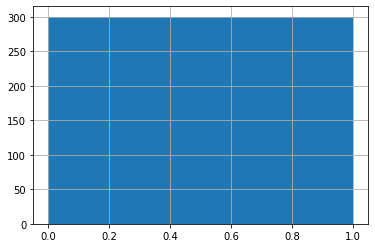

In [122]:
df_results["BB_hand"].hist()

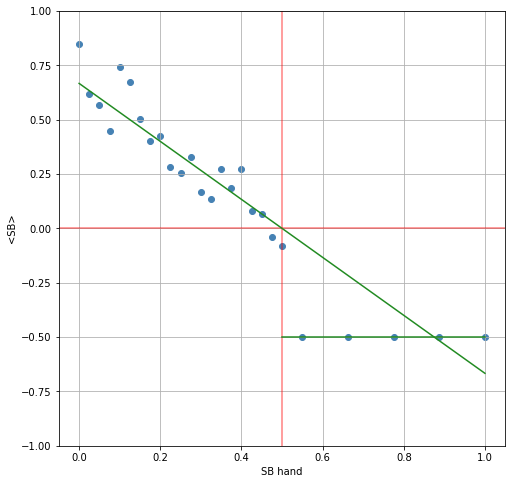

In [153]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

for SB_hand, df in df_results.groupby("SB_hand"):
    EV_SB = df["PnL_SB"].mean()
    
    ax.scatter(SB_hand, EV_SB, color="steelblue")

ax.axhline(0, color="red", alpha=0.5)
ax.axvline(0.5, color="red", alpha=0.5)

# add theoretical line to this
arr_x = np.linspace(0, 1.0, 100)
arr_jam = -4/3*arr_x + 2/3
ax.plot(arr_x, arr_jam, color="forestgreen")

arr_x = np.linspace(0.5, 1, 100)
arr_fold = arr_x*0-0.5
ax.plot(arr_x, arr_fold, color="forestgreen")

ax.set_xlabel("SB hand")
ax.set_ylabel("<SB>")

ax.set_ylim(-1.0, 1.0)
ax.grid()

In [132]:
np.concatenate((np.linspace(0, 0.5, 11), np.linspace(0.55, 1, 5)))

array([0.    , 0.05  , 0.1   , 0.15  , 0.2   , 0.25  , 0.3   , 0.35  ,
       0.4   , 0.45  , 0.5   , 0.55  , 0.6625, 0.775 , 0.8875, 1.    ])